# Oeffikator

## Setup
We start off with global varibale and function definition and important imports.

In [296]:
import json
import requests
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

In [297]:
BVG_URL = "http://bvg-apps-ext.hafas.de/bin/mgate.exe/mgate.exe"
# requires key, x and y coordinates
JSON_GEOLOC = '{"auth":{"aid":"%s","type":"AID"},"client":{"id":"BVG","type":"AND"},"ext":"BVG.1","ver":"1.18","lang":"eng","svcReqL":[{"meth":"ServerInfo","req":{"getServerDateTime":true,"getTimeTablePeriod":false}},{"meth":"LocGeoPos","cfg":{"polyEnc":"GPA"},"req":{"ring":{"cCrd":{"x":%d,"y":%d},"maxDist":20000},"getStops":true,"getPOIs":true,"maxLoc":1}}],"formatted":false}'
# requires key, start_lid, dest_type, extId
JSON_TRIP_SEARCH = '{"auth":{"aid":"%s","type":"AID"},"client":{"id":"BVG","type":"AND"},"ext":"BVG.1","ver":"1.18","lang":"eng","svcReqL":[{"meth":"ServerInfo","req":{"getServerDateTime":true,"getTimeTablePeriod":false}},{"meth":"TripSearch","cfg":{"polyEnc":"GPA"},"req":{"depLocL":[{"type":"P","lid":"%s"}],"arrLocL":[{"type":"%s","extId":"%s"}],"outDate":"20220202","outTime":"120000","outFrwd":true,"gisFltrL":[{"mode":"FB","profile":{"type":"F","linDistRouting":false,"maxdist":2000},"type":"M","meta":"foot_speed_normal"}],"getPolyline":true,"getPasslist":true,"getConGroups":false,"getIST":false,"getEco":false,"extChgTime":-1}}],"formatted":false}'
cdict = {'red':   ((0.0, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),
         'blue':  ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),
         'green': ((0.0, 0.0, 1.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 0.0, 0.0))}
CMAP = mcolors.LinearSegmentedColormap('my_colormap', cdict, 100)

In [298]:
def request_data(json_string):
    data = json.loads(json_string)
    headers = {'Content-type': 'application/json', 'Accept': 'text/plain'}
    r = requests.post(BVG_URL, data=json.dumps(data), headers=headers)
    return json.loads(r.text)

def get_lid(x,y):
    resp = request_data(JSON_GEOLOC % (key, x, y))
    return resp["svcResL"][1]['res']['locL'][0]['lid']

def get_dest(x,y):
    resp = request_data(JSON_GEOLOC % (key, x, y))
    e = resp["svcResL"][1]['res']['locL'][0]['extId']
    t = resp["svcResL"][1]['res']['locL'][0]['type']
    return (e,t)

def get_traveltime(start_lid,dest):
    extId = dest[0]
    dest_type = dest[1]
    resp = request_data(JSON_TRIP_SEARCH % (key, start_lid, dest_type, extId))
    try:
        aTime = resp['svcResL'][1]['res']['outConL'][0]['arr']['aTimeS']
        print(resp['svcResL'][1]['res']['outConL'][0]['arr'])
    except:
        print("error!")
        print(resp)
        return None
    if aTime == None:
        print(resp['svcResL'][1]['res']['outConL'][0]['arr'])
        return None
    return int(aTime)

def compute_distance(x,y,x2,y2):
    coordinate_constant = 10E-7
    coords_1 = (y*coordinate_constant, x*coordinate_constant)
    coords_2 = (y2*coordinate_constant, x2*coordinate_constant)
    return geopy.distance.distance(coords_1, coords_2).km

class TimeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, start_time="12000"):
        self.start_time = datetime.datetime.strptime("120000","%H%M%S")
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X["Time"] = pd.to_datetime(X["Time"], format="%H%M%S")
        X["Time"] = X["Time"] - self.start_time
        X["Time"] = X["Time"].dt.total_seconds()/60
        X = X.dropna()
        return X

## Get your authentification key
Before we get started, let's read or locally stored auth key.

In [299]:
with open("AUTHKEY.txt") as keyfile:
        key = keyfile.read().splitlines()[0]

## Tests
Let's see if can:
 *  Get a location for given coordinates

In [300]:
x = 13430400
y = 52536099
print(get_lid(x,y))

A=4@O=Berlin, Theater unterm Dach@X=13430936@Y=52537482@u=158@U=104@L=900980701@


## Plotting

Let's read data first.

In [301]:
import pandas as pd
df = pd.read_csv("results/results4.txt", sep=",", names=["X","Y","Time"], index_col = 2, na_values="None", dtype = {"X": np.int32, "Y": np.int32, "Time":str})

And then transform it with some custom pipelines.

In [302]:
time_transformer = TimeTransformer()
dfn = time_transformer.transform(df)

In [304]:
dfn

,X,Y,Time
1,13311766,52519960,33.0
2,13311766,52521960,27.0
3,13311766,52523960,23.0
4,13311766,52525960,23.0
5,13311766,52527960,23.0
...,...,...,...
248,13365766,52527960,18.0
249,13365766,52529960,18.0
250,13365766,52531960,17.0
251,13365766,52533960,17.0


It's time to plot:

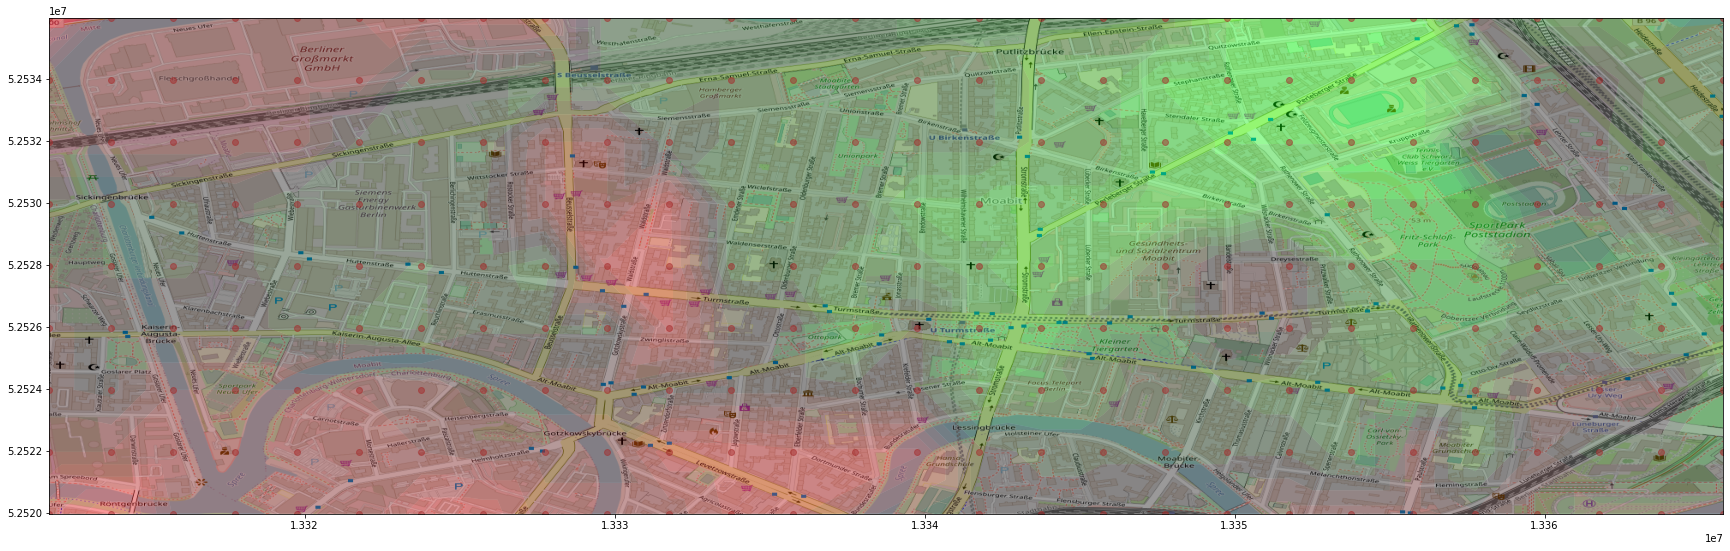

In [311]:
bounding_box = (min(dfn["X"]), max(dfn["X"]), min(dfn["Y"]), max(dfn["Y"]))
levels = np.linspace(np.min(df["Time"]), np.max(dfn["Time"]), 16)
map = plt.imread('maps/map2.png')
fig, ax = plt.subplots(figsize = (30,30))

ax.imshow(map, extent = bounding_box, aspect= 'equal')
ax.set_xlim(bounding_box[0]-0.002,bounding_box[1]+0.002)
ax.set_ylim(bounding_box[2]-0.002,bounding_box[3]+0.002)
ax.tricontourf(dfn["X"], dfn["Y"], dfn["Time"], levels=levels, alpha= 0.4, cmap = CMAP, antialiased=True)
#Displaying target locations
#ax.scatter(dfn["X"], dfn["Y"], alpha=0.5, color = "brown")

## Previous code

In [22]:
import json
import requests
url = "http://bvg-apps-ext.hafas.de/bin/mgate.exe/mgate.exe"
s1 = '{"auth":{"aid":"%s","type":"AID"},"client":{"id":"BVG","type":"AND"},"ext":"BVG.1","ver":"1.18","lang":"eng","svcReqL":[{"meth":"ServerInfo","req":{"getServerDateTime":true,"getTimeTablePeriod":false}},{"meth":"LocGeoPos","cfg":{"polyEnc":"GPA"},"req":{"ring":{"cCrd":{"x":%d,"y":%d},"maxDist":20000},"getStops":true,"getPOIs":true,"maxLoc":1}}],"formatted":false}'
s1 = s1 % (key,13430400,52536099)
data = json.loads(s1)
headers = {'Content-type': 'application/json', 'Accept': 'text/plain'}
r = requests.post(url, data=json.dumps(data), headers=headers)
#print(r.text)
resp = json.loads(r.text)
resp["svcResL"][1]['res']['locL'][0]['lid']

'A=4@O=Berlin, Theater unterm Dach@X=13430936@Y=52537482@u=158@U=104@L=900980701@'

In [145]:
rp = """{"ver":"1.18","ext":"BVG.1","lang":"eng","id":"tm2ktgxukkk3y2wg","err":"OK","svcResL":[{"meth":"ServerInfo","err":"OK","res":{"common":{"locL":[],"prodL":[],"polyL":[],"layerL":[{"id":"standard","name":"standard","index":0,"annoCnt":0}],"crdSysL":[{"id":"standard","index":0,"type":"WGS84"}],"opL":[],"remL":[],"icoL":[]},"sD":"20220202","sT":"114242","enc":"ISO-8859-1","planrtTS":"1643798528"}},{"meth":"LocGeoPos","err":"OK","res":{"common":{"locL":[],"prodL":[{"pid":"L::2::Tram::B3041857784::Tram_3041857784_M10::*","name":"M10","nameS":"M10","icoX":0,"cls":4,"prodCtx":{"name":"M10","line":"M10","lineId":"M10","catOut":"Tram    ","catOutS":"T","catOutL":"Tram    "},"himIdL":["HIM_FREETEXT_75748","HIM_FREETEXT_52249"]}],"polyL":[],"layerL":[{"id":"standard","name":"standard","index":0,"annoCnt":0}],"crdSysL":[{"id":"standard","index":0,"type":"WGS84"}],"opL":[],"remL":[],"icoL":[{"res":"prod_gen"},{"res":"POI"}]},"locL":[{"lid":"A=4@O=Berlin, Theater unterm Dach@X=13430936@Y=52537482@u=158@U=104@L=900980701@","type":"P","name":"Berlin, Theater unterm Dach","icoX":1,"extId":"900980701","state":"F","crd":{"x":13430936,"y":52537482,"layerX":0,"crdSysX":0},"dist":158,"dur":309}]}}]}
"""
resp = json.loads(rp)
a = resp["svcResL"][1]['res']['locL'][0]['extId']
b = resp["svcResL"][1]['res']['locL'][0]['type']
print(a,b)

resp

900980701 P


{'ver': '1.18',
 'ext': 'BVG.1',
 'lang': 'eng',
 'id': 'tm2ktgxukkk3y2wg',
 'err': 'OK',
 'svcResL': [{'meth': 'ServerInfo',
   'err': 'OK',
   'res': {'common': {'locL': [],
     'prodL': [],
     'polyL': [],
     'layerL': [{'id': 'standard',
       'name': 'standard',
       'index': 0,
       'annoCnt': 0}],
     'crdSysL': [{'id': 'standard', 'index': 0, 'type': 'WGS84'}],
     'opL': [],
     'remL': [],
     'icoL': []},
    'sD': '20220202',
    'sT': '114242',
    'enc': 'ISO-8859-1',
    'planrtTS': '1643798528'}},
  {'meth': 'LocGeoPos',
   'err': 'OK',
   'res': {'common': {'locL': [],
     'prodL': [{'pid': 'L::2::Tram::B3041857784::Tram_3041857784_M10::*',
       'name': 'M10',
       'nameS': 'M10',
       'icoX': 0,
       'cls': 4,
       'prodCtx': {'name': 'M10',
        'line': 'M10',
        'lineId': 'M10',
        'catOut': 'Tram    ',
        'catOutS': 'T',
        'catOutL': 'Tram    '},
       'himIdL': ['HIM_FREETEXT_75748', 'HIM_FREETEXT_52249']}],
     '

In [71]:
import geopy.distance

F = 10E-7
def distance(x,y,x2,y2):
    coords_1 = (y*F, x*F)
    coords_2 = (y2*F, x2*F)
    return geopy.distance.distance(coords_1, coords_2).km


F = 10E-7
import json
import requests
url = "http://bvg-apps-ext.hafas.de/bin/mgate.exe/mgate.exe"
s1 = '{"auth":{"aid":"%s","type":"AID"},"client":{"id":"BVG","type":"AND"},"ext":"BVG.1","ver":"1.18","lang":"eng","svcReqL":[{"meth":"ServerInfo","req":{"getServerDateTime":true,"getTimeTablePeriod":false}},{"meth":"LocGeoPos","cfg":{"polyEnc":"GPA"},"req":{"ring":{"cCrd":{"x":%d,"y":%d},"maxDist":20000},"getStops":true,"getPOIs":true,"maxLoc":1}}],"formatted":false}'
s1 = s1 % (key)
teststops = []
for x in range(13440000,13490000,2000):
    print(x)
    y= 52536099
    
    s1_con = s1 % (x,y)
    print(distance(x*F,y*F,13430400*F,52536099*F))
    data = json.loads(s1_con)
    headers = {'Content-type': 'application/json', 'Accept': 'text/plain'}
    r = requests.post(url, data=json.dumps(data), headers=headers)
    #print(r.text)
    resp = json.loads(r.text)
    stop = resp["svcResL"][1]['res']['locL'][0]['lid']
    teststops.append(stop)

13440000
0.6514041417555199
13447000
1.1263863268002978
13454000
1.601368509196995
13461000
2.076350687828952
13468000
2.5513328615796285
13475000
3.0263150293321215
13482000
3.5012971899698933
13489000
3.9762793423762823


In [72]:
teststops

['A=1@O=Arnswalder Platz (Berlin)@X=13437390@Y=52534093@u=284@U=86@L=900110025@',
 'A=1@O=Kniprodestr./Storkower Str. (Berlin)@X=13449562@Y=52537185@u=211@U=86@L=900110026@',
 'A=1@O=Storkower Str./Gewerbegebiet (Berlin)@X=13451755@Y=52535334@u=190@U=86@L=900110526@',
 'A=4@O=Berlin, Sportplatz am Volkspark Prenzlauer Berg@X=13468313@Y=52536080@u=495@U=104@L=900981283@',
 'A=4@O=Berlin, Sportplatz am Volkspark Prenzlauer Berg@X=13468313@Y=52536080@u=21@U=104@L=900981283@',
 'A=1@O=Hohenschönhauser Str. (Berlin)@X=13473823@Y=52535585@u=97@U=86@L=900150711@',
 'A=1@O=Altenhofer Str. (Berlin)@X=13480170@Y=52534929@u=179@U=86@L=900150509@',
 'A=1@O=Zechliner Str. (Berlin)@X=13487154@Y=52533949@u=269@U=86@L=900160513@']

In [119]:
#messung wie weit die generierte station und die urpsprünglichen koordinaten auseinander liegen
#ist 350m wenig genug?
distance(13355768,52635339,13350744,52636099)

0.3504861181079758

In [126]:
distance(13355000*F,52635000*F,13357000*F,52635000*F)*1000

135.40406796948972

In [117]:
import json
import requests
url = "http://bvg-apps-ext.hafas.de/bin/mgate.exe/mgate.exe"
s1 = '{"auth":{"aid":"%s","type":"AID"},"client":{"id":"BVG","type":"AND"},"ext":"BVG.1","ver":"1.18","lang":"eng","svcReqL":[{"meth":"ServerInfo","req":{"getServerDateTime":true,"getTimeTablePeriod":false}},{"meth":"TripSearch","cfg":{"polyEnc":"GPA"},"req":{"depLocL":[{"type":"P","lid":"A=4@O=Berlin, Prenzlkasper@X=13424679@Y=52536107@u=109@U=104@L=900980734@"}],"arrLocL":[{"type":"S","extId":"900200507"}],"outDate":"20220202","outTime":"120000","outFrwd":true,"gisFltrL":[{"mode":"FB","profile":{"type":"F","linDistRouting":false,"maxdist":2000},"type":"M","meta":"foot_speed_normal"}],"getPolyline":true,"getPasslist":true,"getConGroups":false,"getIST":false,"getEco":false,"extChgTime":-1}}],"formatted":false}'
s1 = s1 % (key)
#s1 = s1 % (13430400,52536099)
data = json.loads(s1)
headers = {'Content-type': 'application/json', 'Accept': 'text/plain'}
r = requests.post(url, data=json.dumps(data), headers=headers)
#print(r.text)
resp = json.loads(r.text)
for x in range(len(resp['svcResL'][1]['res']['outConL'])):
    print(resp['svcResL'][1]['res']['outConL'][x]['arr']['aTimeS'])

    print("")

130100

130200

132100



In [4]:
length = len(range(13368007,13390623,2000)) * len(range(52518214,52523802,2000))
length2 = len(range(13368007,13390623,2000)) * len(range(52518214,52543802,2000))
print(length)
print(length2)

36
156


In [2]:
import geopy.distance

import json
import requests
#test setup: x,y
#punkt 1:52523802, 13368007
#punkt 2:52518214, 13390623
#startpunkt beier
#punkt 3:52541350,  13366540
# x sind die 13er zahlen
F = 10E-7
def distance(x,y,x2,y2):
    coords_1 = (y*F, x*F)
    coords_2 = (y2*F, x2*F)
    return geopy.distance.distance(coords_1, coords_2).km



quit()
atimes = []
i =0

#links oben moabit 52.53746136684121, 13.31176629214652
#rechts unten moabit 52.51996891399787, 13.366440440707555
#xxxxxxxxxx
X1=13311766
Y1=52519960


X2=13366440
Y2=52537461

print("X distance gps",X2-X1)
print("Y distance gps", Y2-Y1)

print("X distance km",distance(X1,Y1,X2,Y1))
print("Y distance km",distance(X2,Y1,X2,Y2))

length = len(range(X1,X2,2000)) * len(range(Y1,Y2,2000))
print("anzahl berechnungen:",length)

start_lid = get_lid(13366540,52541350)
print(start_lid)


for x in range(13368007,13390623,2000):
    for y in range(52518214,52543802,2000):
        try:
            print(x,y)
            i+=1
            print(i/length*100,"% Fortschritt, es fehlen ",length - i)

            dest = get_dest(x,y)
            #print(get_lid(x,y))
            print("destination paramteres:",dest)
            time = get_traveltime(start_lid,dest)
            print(time)
            f = open("results3.txt","a+")
            f.write(str(x)+","+str(y)+","+str(i)+","+str(time)+"\n")
            f.close()

            #print(distance(13366540,52541350,x,y))
            atimes.append((x,y,time))
        except ValueError:
            with open("results3.txt","a+") as f:
                f.write("error"+str(i)+",x="+str(x)+", "+str(y)+"\n")

            continue
            
            
            

X distance gps 54674
Y distance gps 17501
X distance km 3.711242311869597
Y distance km 1.947465357513018
anzahl berechnungen: 252
A=1@O=U Reinickendorfer Str./Fennstr. (Berlin)@X=13368713@Y=52541195@u=148@U=86@L=900008104@
13368007 52518214
0.3968253968253968 % Fortschritt, es fehlen  251
destination paramteres: ('900980718', 'P')
{'locX': 1, 'aOutR': True, 'aTimeS': '122300', 'type': 'N'}
122300
13368007 52520214
0.7936507936507936 % Fortschritt, es fehlen  250
destination paramteres: ('900981032', 'P')
{'locX': 1, 'aOutR': True, 'aTimeS': '122100', 'type': 'N'}
122100
13368007 52522214
1.1904761904761905 % Fortschritt, es fehlen  249


KeyboardInterrupt: 

In [1]:
def get_lid(x,y):
    url = "http://bvg-apps-ext.hafas.de/bin/mgate.exe/mgate.exe"
    s1 = '{"auth":{"aid":"%s","type":"AID"},"client":{"id":"BVG","type":"AND"},"ext":"BVG.1","ver":"1.18","lang":"eng","svcReqL":[{"meth":"ServerInfo","req":{"getServerDateTime":true,"getTimeTablePeriod":false}},{"meth":"LocGeoPos","cfg":{"polyEnc":"GPA"},"req":{"ring":{"cCrd":{"x":%d,"y":%d},"maxDist":20000},"getStops":true,"getPOIs":true,"maxLoc":1}}],"formatted":false}'
    s1 = s1 % (key,x,y)
    data = json.loads(s1)
    headers = {'Content-type': 'application/json', 'Accept': 'text/plain'}
    r = requests.post(url, data=json.dumps(data), headers=headers)
    #print(r.text)
    resp = json.loads(r.text)
    return resp["svcResL"][1]['res']['locL'][0]['lid']

def get_dest(x,y):
    url = "http://bvg-apps-ext.hafas.de/bin/mgate.exe/mgate.exe"
    s1 = '{"auth":{"aid":"%s","type":"AID"},"client":{"id":"BVG","type":"AND"},"ext":"BVG.1","ver":"1.18","lang":"eng","svcReqL":[{"meth":"ServerInfo","req":{"getServerDateTime":true,"getTimeTablePeriod":false}},{"meth":"LocGeoPos","cfg":{"polyEnc":"GPA"},"req":{"ring":{"cCrd":{"x":%d,"y":%d},"maxDist":20000},"getStops":true,"getPOIs":true,"maxLoc":1}}],"formatted":false}'
    s1 = s1 % (key,x,y)
    data = json.loads(s1)
    headers = {'Content-type': 'application/json', 'Accept': 'text/plain'}
    r = requests.post(url, data=json.dumps(data), headers=headers)
    #print(r.text)
    resp = json.loads(r.text)
    e = resp["svcResL"][1]['res']['locL'][0]['extId']
    t = resp["svcResL"][1]['res']['locL'][0]['type']
    return (e,t)

def get_traveltime(start_lid,dest):
    extId = dest[0]
    dest_type = dest[1]
    url = "http://bvg-apps-ext.hafas.de/bin/mgate.exe/mgate.exe"
    s1 = '{"auth":{"aid":"%s","type":"AID"},"client":{"id":"BVG","type":"AND"},"ext":"BVG.1","ver":"1.18","lang":"eng","svcReqL":[{"meth":"ServerInfo","req":{"getServerDateTime":true,"getTimeTablePeriod":false}},{"meth":"TripSearch","cfg":{"polyEnc":"GPA"},"req":{"depLocL":[{"type":"P","lid":"%s"}],"arrLocL":[{"type":"%s","extId":"%s"}],"outDate":"20220202","outTime":"120000","outFrwd":true,"gisFltrL":[{"mode":"FB","profile":{"type":"F","linDistRouting":false,"maxdist":2000},"type":"M","meta":"foot_speed_normal"}],"getPolyline":true,"getPasslist":true,"getConGroups":false,"getIST":false,"getEco":false,"extChgTime":-1}}],"formatted":false}'
    #s1: 1. lid, 2. type, 3. extId
    s1 = s1 % (key,start_lid,dest_type, extId)
    data = json.loads(s1)
    headers = {'Content-type': 'application/json', 'Accept': 'text/plain'}
    r = requests.post(url, data=json.dumps(data), headers=headers)
    #print(r.text)
    resp = json.loads(r.text)
    #for x in range(len(resp['svcResL'][1]['res']['outConL'])):
    try:
        aTime = resp['svcResL'][1]['res']['outConL'][0]['arr']['aTimeS']
        print(resp['svcResL'][1]['res']['outConL'][0]['arr'])
    except:
        print("error!")
        print(resp)
        return None
    if aTime == None:
        print(resp['svcResL'][1]['res']['outConL'][0]['arr'])

        return None
    return int(aTime)


In [6]:
with open("results2.txt") as r:
        X = []
        Y = []
        L = []
        for l in r:
            if "error" in l:
                continue
            x = l.split(",")[0]
            y = l.split(",")[1]
            time = l.split(",")[3]
            hour = time[0:2]
            minutes = time[2:4]
            length = int(minutes) + (int(hour) - 12)*60
            #print(length)
            X.append(int(x))
            Y.append(int(y))
            L.append(length)

In [7]:
len(L)

149

/tmp/ipykernel_7796/1715061623.py:17: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


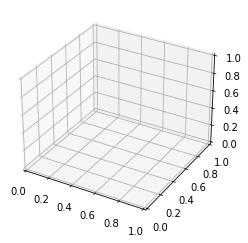

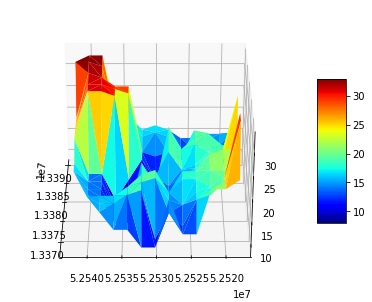

Making animation


In [9]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from sys import argv
import matplotlib.pyplot as plt
ax = plt.axes(projection='3d')
from mpl_toolkits import mplot3d
import matplotlib.animation as animation
import numpy as np
#fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
#ax.scatter3D(np.array(X),np.array(Y),np.array(length))

#ax.scatter3D(X,Y,L,c=L)

fig = plt.figure()
ax = Axes3D(fig)
ax.view_init(azim=180)

surf = ax.plot_trisurf(X, Y, L, cmap=cm.jet, linewidth=0.1)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.savefig('teste.pdf')
plt.show()



print("Making animation")
